In [11]:
import pandas as pd
import numpy as np

In [12]:
%load_ext autoreload

/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


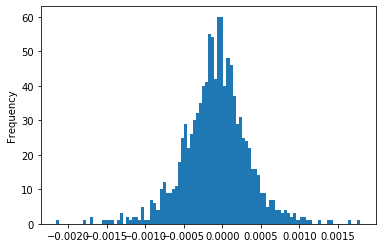

In [14]:
from gensim.models.word2vec import Word2Vec 
#import logging
import copy
from scipy.spatial.distance import cosine
from glob import glob
from utils_parallel import *
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
START_YEAR = 1850
END_YEAR = 1852
ROOT = "../researchdrive/RSC-KB-pilot"
OUTPUT = "../models/{}-{}.w2v.model".format(START_YEAR,END_YEAR)

In [ ]:
sentences = SentIterator(ROOT,date_range=(START_YEAR,END_YEAR),tokenized=False,n_jobs=-1)

In [ ]:
filtered_sents = sentences.filter_lines('(?:vrouw*|moeder*)')

In [ ]:
sent_df = pd.DataFrame([s.split('<SEP>') for s in filtered_sents],columns=['doc_id','text'])
sent_df.head()

In [ ]:
csvs = glob('../researchdrive/RSC-KB-pilot/Identifiers/Identifiers_18*.csv')

In [ ]:
df = pd.concat([pd.read_csv(f,sep=';',index_col=0) for f in csvs],axis=0)
df.head()

In [ ]:
def get_doc_id(identifier):
    try:
        _,_,i,_,j,_ = identifier.split(":") 
        return '_'.join([i,j])
    except:
        return 'NaN'
    
df['doc_id'] = df.identifier.apply(get_doc_id)
print(np.sum(df.doc_id=='NaN'))

In [ ]:
df_merged = sent_df.merge(df,how='left',right_on='doc_id',left_on='doc_id')
print(df_merged.shape)
#df_merged.head()

In [ ]:
daily_articles = df_merged.groupby('date')['text'].apply('\n'.join)
daily_articles = pd.DataFrame(daily_articles,columns=['text'])
daily_articles['doc_id'] = ''
daily_articles.head()

In [ ]:
model = Word2Vec.load('../models/{0}-{1}.w2v.model'.format(START_YEAR,END_YEAR))
p1 = [w for w,v in model.wv.most_similar('vrouw',topn=20)] + ['vrouw']
p2 = [w for w,v in model.wv.most_similar('man',topn=20)] + ['man']
target = [w for w,v in model.wv.most_similar('kind',topn=20)] + ['kind']
print(p1)
print(p2)
print(target)

In [ ]:
cosine_sim = lambda v1,v2: 1 - cosine(v1,v2) 
euclid_dist = lambda v1,v2: - np.linalg.norm(v1-v2,ord=2)
average_vector = lambda words,model : np.mean([model.wv.__getitem__(w) for w in words if model.wv.__contains__(w)],axis=0)

def compute_bias(p1,p2,target,model,metric=cosine_sim):
    av_v1 = average_vector(p1,model); av_v2 = average_vector(p2,model)
    return np.mean([metric(av_v1,model.wv.__getitem__(w)) - \
                      metric(av_v2,model.wv.__getitem__(w)) for w in target 
                           if w in model.wv])


In [ ]:
update_sents = [preprocess_sent(t.text,t.doc_id) for i,t in daily_articles.iterrows()]

In [ ]:
EPOCH = 4

In [ ]:
def compare_bias(i,sent,p1,p2,target):
    model = Word2Vec.load('../models/{0}-{1}.w2v.model'.format(START_YEAR,END_YEAR))
    model.train([sent],total_examples=len([sent]),epochs=EPOCH)
    orig_model = Word2Vec.load('../models/{0}-{1}.w2v.model'.format(START_YEAR,END_YEAR))
    return (i,sent,compute_bias(p1,p2,target,model) - compute_bias(p1,p2,target,orig_model))

In [ ]:
scores = Parallel(n_jobs=-1)(delayed(compare_bias)(i,sent,p1,p2,target) for i,sent in tqdm(enumerate(update_sents)))

In [ ]:
import pickle
with open('../researchdrive/processed/biasbatch.pckl','wb') as out_pickle:
    pickle.dump(scores,out_pickle)